In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from textwrap import wrap

%matplotlib inline

pd.options.display.max_columns = 9999
np.seterr(divide="ignore");
plt.style.use('ggplot')

# Import data

In [2]:
all_data = pd.read_csv("all_data.csv")
head_data = pd.read_csv("head_mh.csv")
migrant_data = pd.read_csv("migrant_data.csv")
spouse_data = pd.read_csv("spouse_mh.csv")
dummy_data = pd.read_csv("total_dummy_head.csv")

In [3]:
df_house = pd.read_stata("house9_081815.dta")
df_person = pd.read_stata("pers9_072215.dta")
df_head = pd.read_stata("lifehead9_080615.dta")
df_spouse = pd.read_stata("lifespouse9_080615.dta")
df_other = pd.read_stata("lifeother9_072215.dta")

 
## <center>Overview:</center> <br>
**<center>1, Occupation Distribution <br>
2, Education Distribution <br>
3, Age Distribution <br>
4, Wage Distribution <br>
5, Land Distribution <br>
6, Household Size Distribution</center>** <br>


# Occupation Distribution

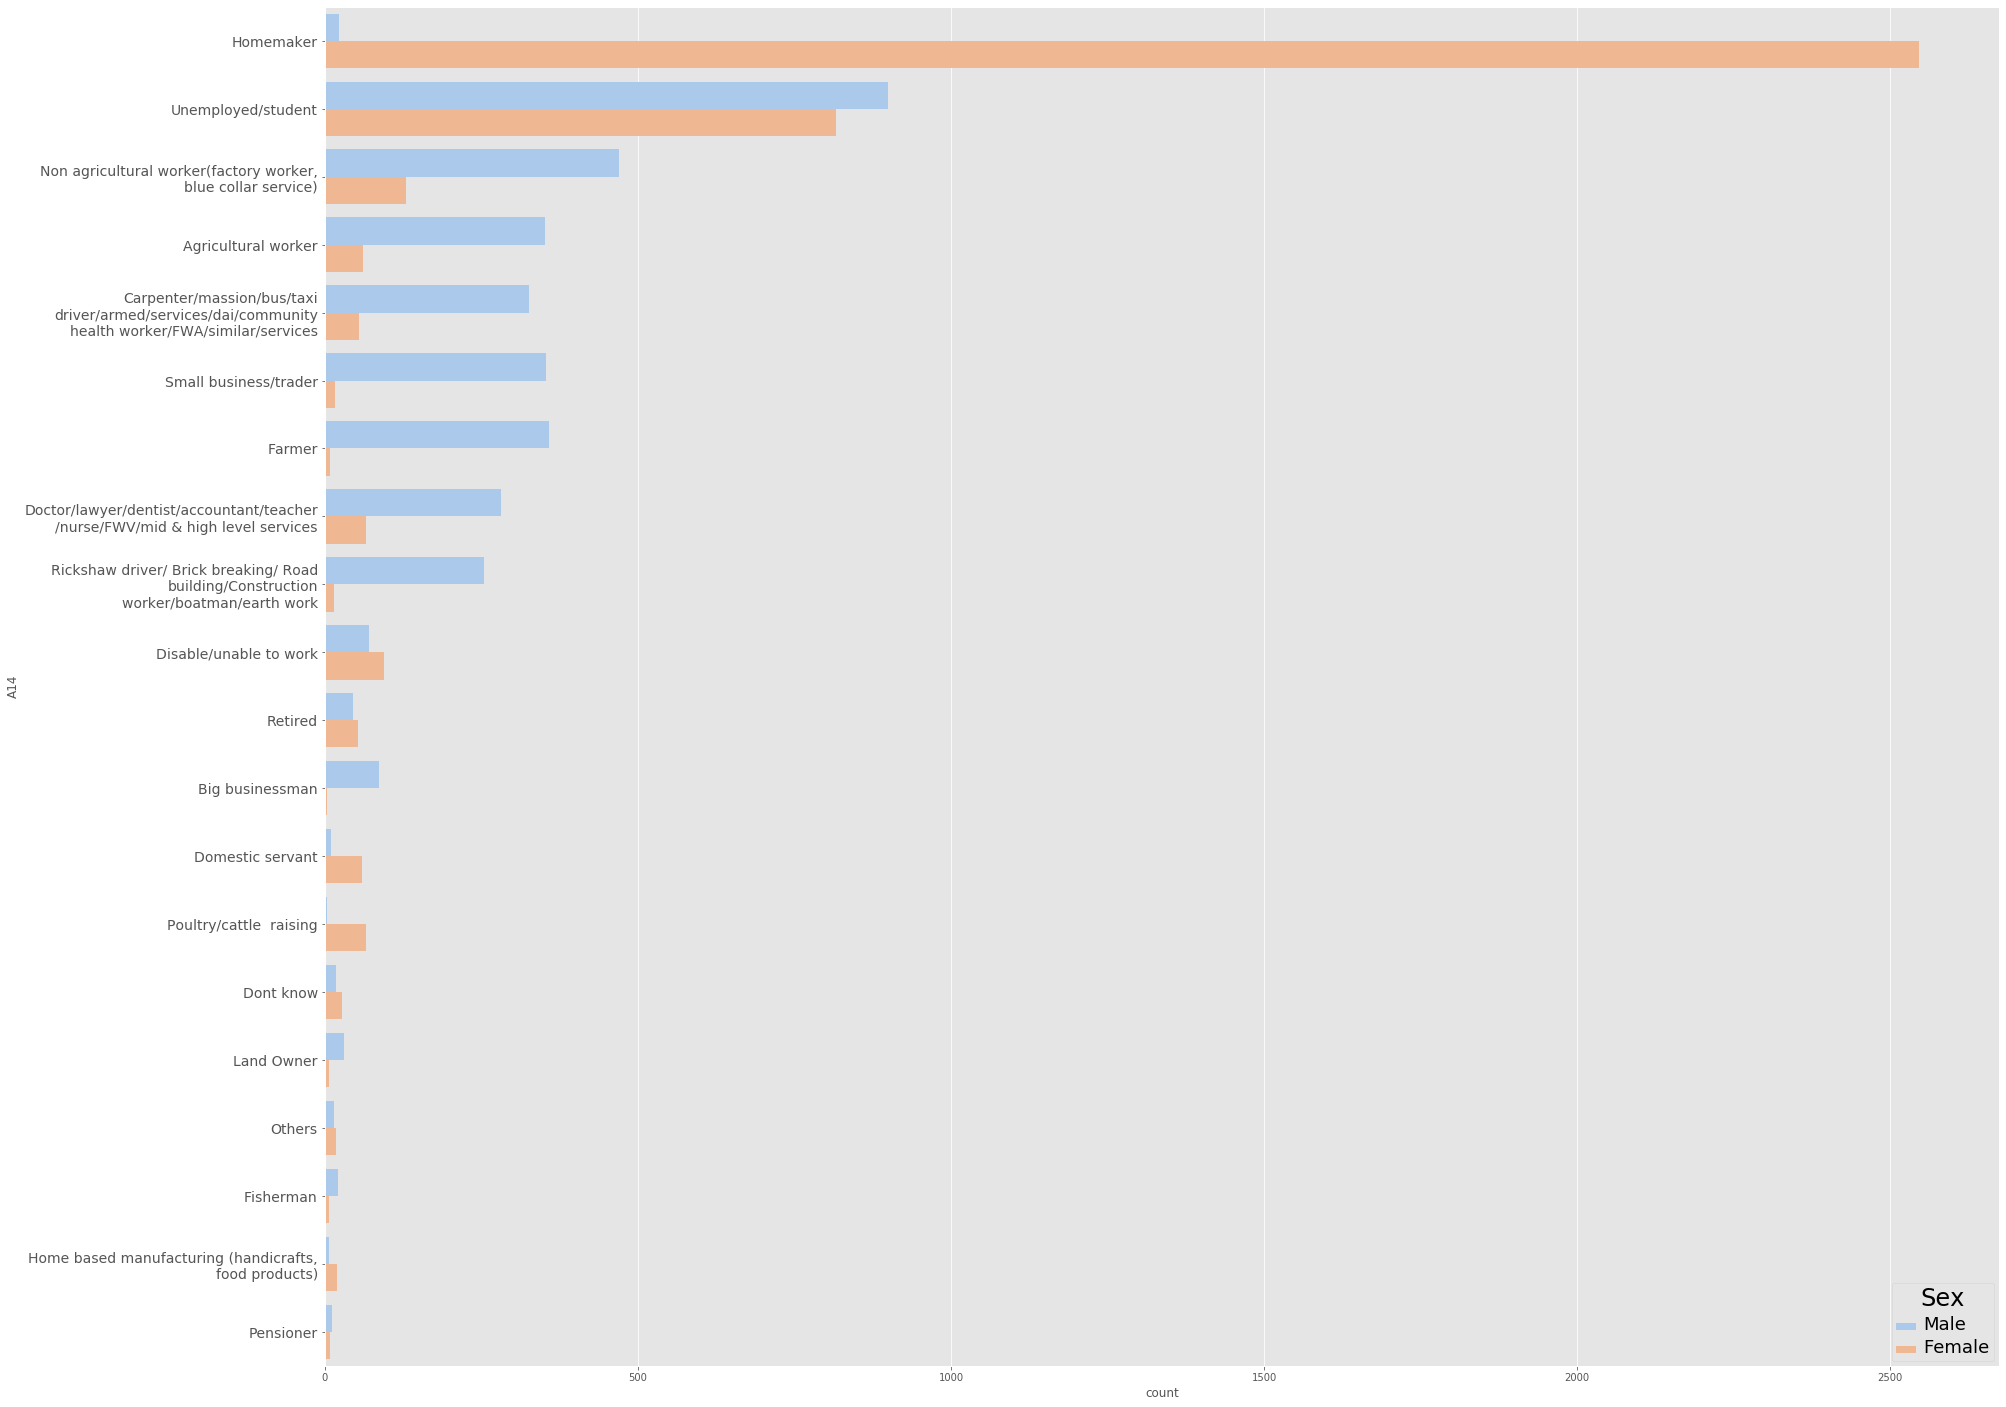

In [83]:
# occupation distributions for male(blue) and female(orange)

plt.figure(figsize=(30, 25))
plot1 = sns.countplot(y = "A14", hue="Sex", data=df_person.rename(columns={"A03": "Sex"}), palette="pastel", order=df_person["A14"].value_counts().index)
labels = [label.get_text() for label in plot1.get_yticklabels()]
labels = ["\n".join(wrap(label, 40)) for label in labels]
plot1.set_yticklabels(labels, fontsize=14);
plt.setp(plot1.get_legend().get_texts(), fontsize='18');
plt.setp(plot1.get_legend().get_title(), fontsize='24');

# Education level distribution

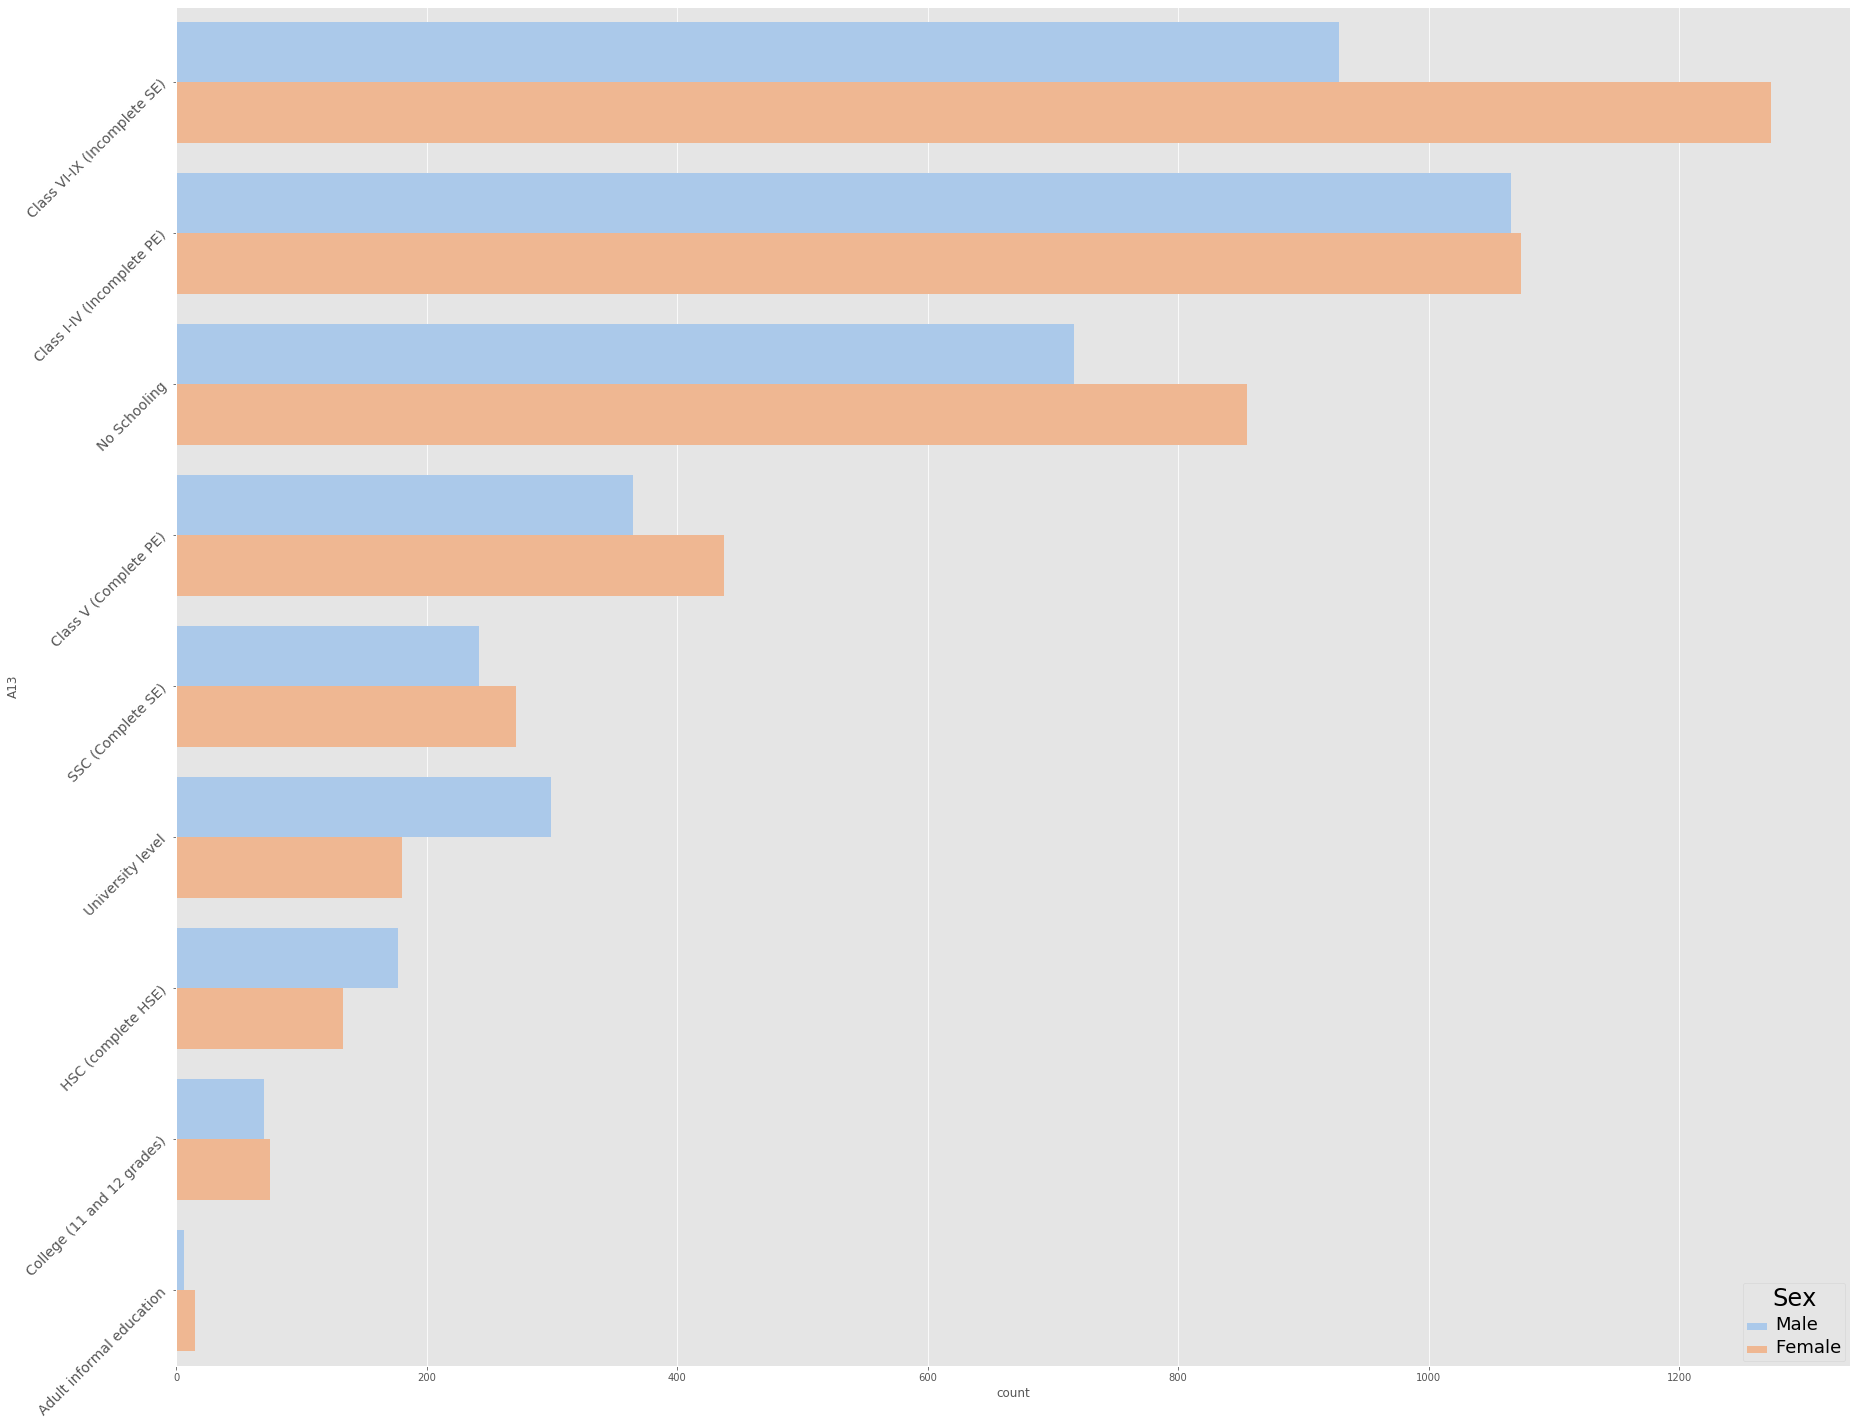

In [84]:
# Education level distributions for male(blue) and female(orange)

plt.figure(figsize=(30, 25))
plot1 = sns.countplot(y = "A13", hue="Sex", data=df_person.rename(columns={"A03": "Sex"}), palette="pastel", order=df_person["A13"].value_counts().index)
plot1.set_yticklabels(plot1.get_yticklabels(), rotation=45, fontsize=14);
plt.setp(plot1.get_legend().get_texts(), fontsize='18');
plt.setp(plot1.get_legend().get_title(), fontsize='24');

# Age Distribution

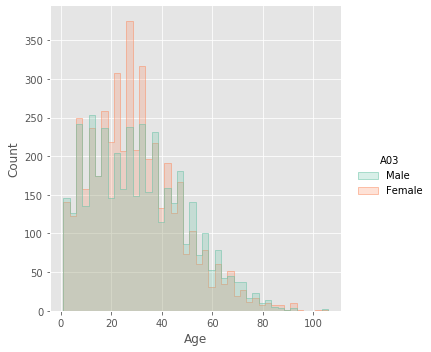

In [85]:
# Age distributions for male and female

df_person["Age"] = df_person.apply(lambda row: (2015 - int(row["A08"])) if ((row["A08"]!="Missing/NA") & (row["A09"]=="Missing/NA")) else ("N/A"), axis=1)

sns.displot(df_person[df_person['Age'].astype(str).str.isdigit()], x="Age", hue="A03", element="step", palette="Set2")

<Figure size 1440x2160 with 0 Axes>

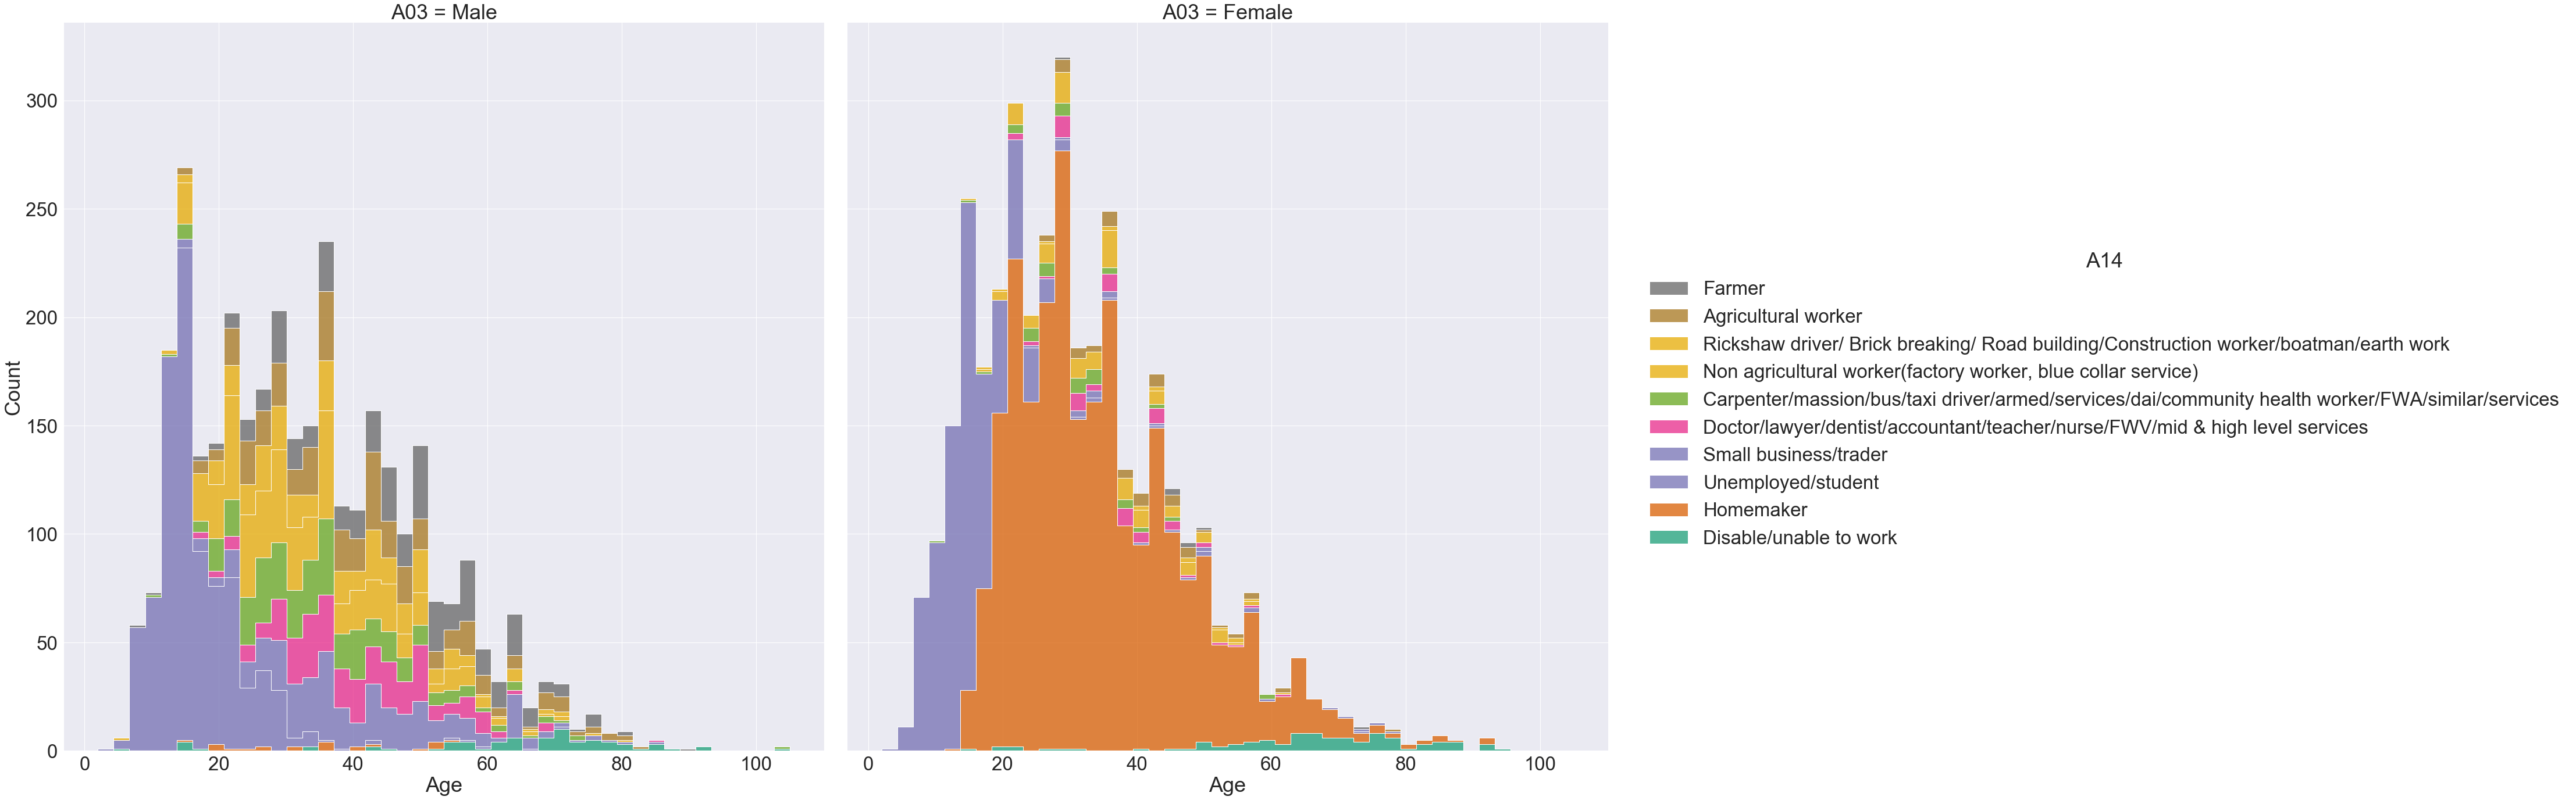

In [86]:
# Job distribution for different age groups
# Here we only look at the top 10 most popular jobs

plt.figure(figsize=(20, 30));
sns.set(font_scale=3)
top_jobs = df_person["A14"].value_counts().sort_values(ascending=False).index[:10]
df_person_top_jobs = df_person[(df_person['Age'].astype(str).str.isdigit()) & (df_person["A14"].isin(top_jobs))].copy()
df_person_top_jobs["A14"] = df_person_top_jobs["A14"].cat.remove_unused_categories()


plot = sns.displot(df_person_top_jobs, x="Age", hue="A14", col="A03", element="step", palette="Dark2_r", multiple="stack", height=20)
sns.set(font_scale=1)


In [15]:
# Summary statistics of age

pd.to_numeric(df_person[df_person['Age'].astype(str).str.isdigit()]["Age"]).describe()

count    8818.000000
mean       30.083466
std        18.093994
min         1.000000
25%        16.000000
50%        28.000000
75%        42.000000
max       106.000000
Name: Age, dtype: float64

# Wage Distribution

In [141]:
# Summary statistics for wage
# Data source: Internal: Wage (taka) - Last, Head/Spouse

df_person["D1_10Al"].describe(percentiles = [0.05, .25, .5, .75, 0.995], include='all')

count    1.520000e+03
mean     2.320577e+04
std      4.440521e+05
min      0.000000e+00
5%       0.000000e+00
25%      0.000000e+00
50%      2.000000e+02
75%      3.000000e+03
99.5%    4.405000e+04
max      9.999998e+06
Name: D1_10Al, dtype: float64

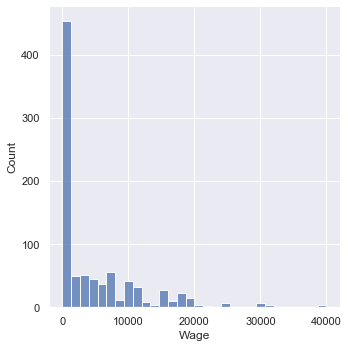

In [92]:
# Wage distribution plot (Not very useful because it's not the actual wage data)

plot = sns.displot(df_person[(df_person["D1_10Al"].isnull() == False) & (df_person["D1_10Al"]>0.1) & (df_person["D1_10Al"]<45000)]["D1_10Al"], bins=30);
plot.set(xlabel="Wage")

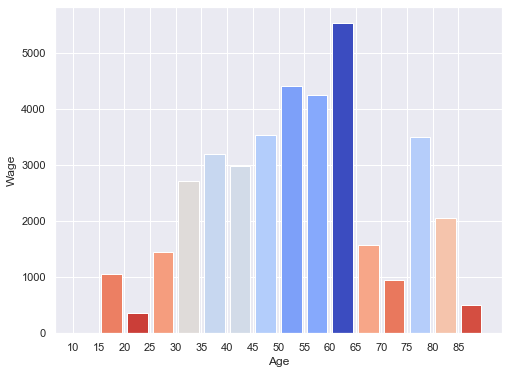

In [93]:
# Average salary for each age group(5 years) after removing the outliers

df_person_temp = df_person[(df_person["D1_10Al"].isnull() == False) 
                             & (df_person["D1_10Al"]<45000) 
                             & (df_person['Age'].astype(str).str.isdigit())]
age_list = [age for age in range(10, 90, 5)]
wage_list = []

for age in range(10, 90, 5):
    average_wage = df_person_temp[(df_person_temp["Age"].astype("int32")>=age) & (df_person_temp["Age"].astype("int32")<age+5)]["D1_10Al"].astype("float64").mean()
    wage_list.append(average_wage)
    
wage_df = pd.DataFrame({"Age": age_list, "Average_wage": wage_list}).fillna(0)     

plt.figure(figsize=(8, 6))
cmap = plt.cm.get_cmap('coolwarm_r')
colors = cmap(wage_df["Average_wage"]/wage_df["Average_wage"].max())
x = np.arange(len(wage_df["Age"])) + 0.5
plt.bar(x, wage_df["Average_wage"], width=0.8, color=colors)
plt.xticks(x-0.5, wage_df["Age"]);
plt.xlabel("Age");
plt.ylabel("Wage");

In [94]:
# Remove outliers
df_person_salary = df_person[df_person["D1_10Al"].isnull()==False]
df_person_salary = df_person_salary[(np.abs(stats.zscore(df_person_salary["D1_10Al"]) < 3))]


# Rank the labels
ranking1 = df_person_salary.groupby("A14")["D1_10Al"].mean().sort_values(ascending=False).index
ranking2 = df_person_salary.groupby("A13")["D1_10Al"].mean().sort_values(ascending=False).index

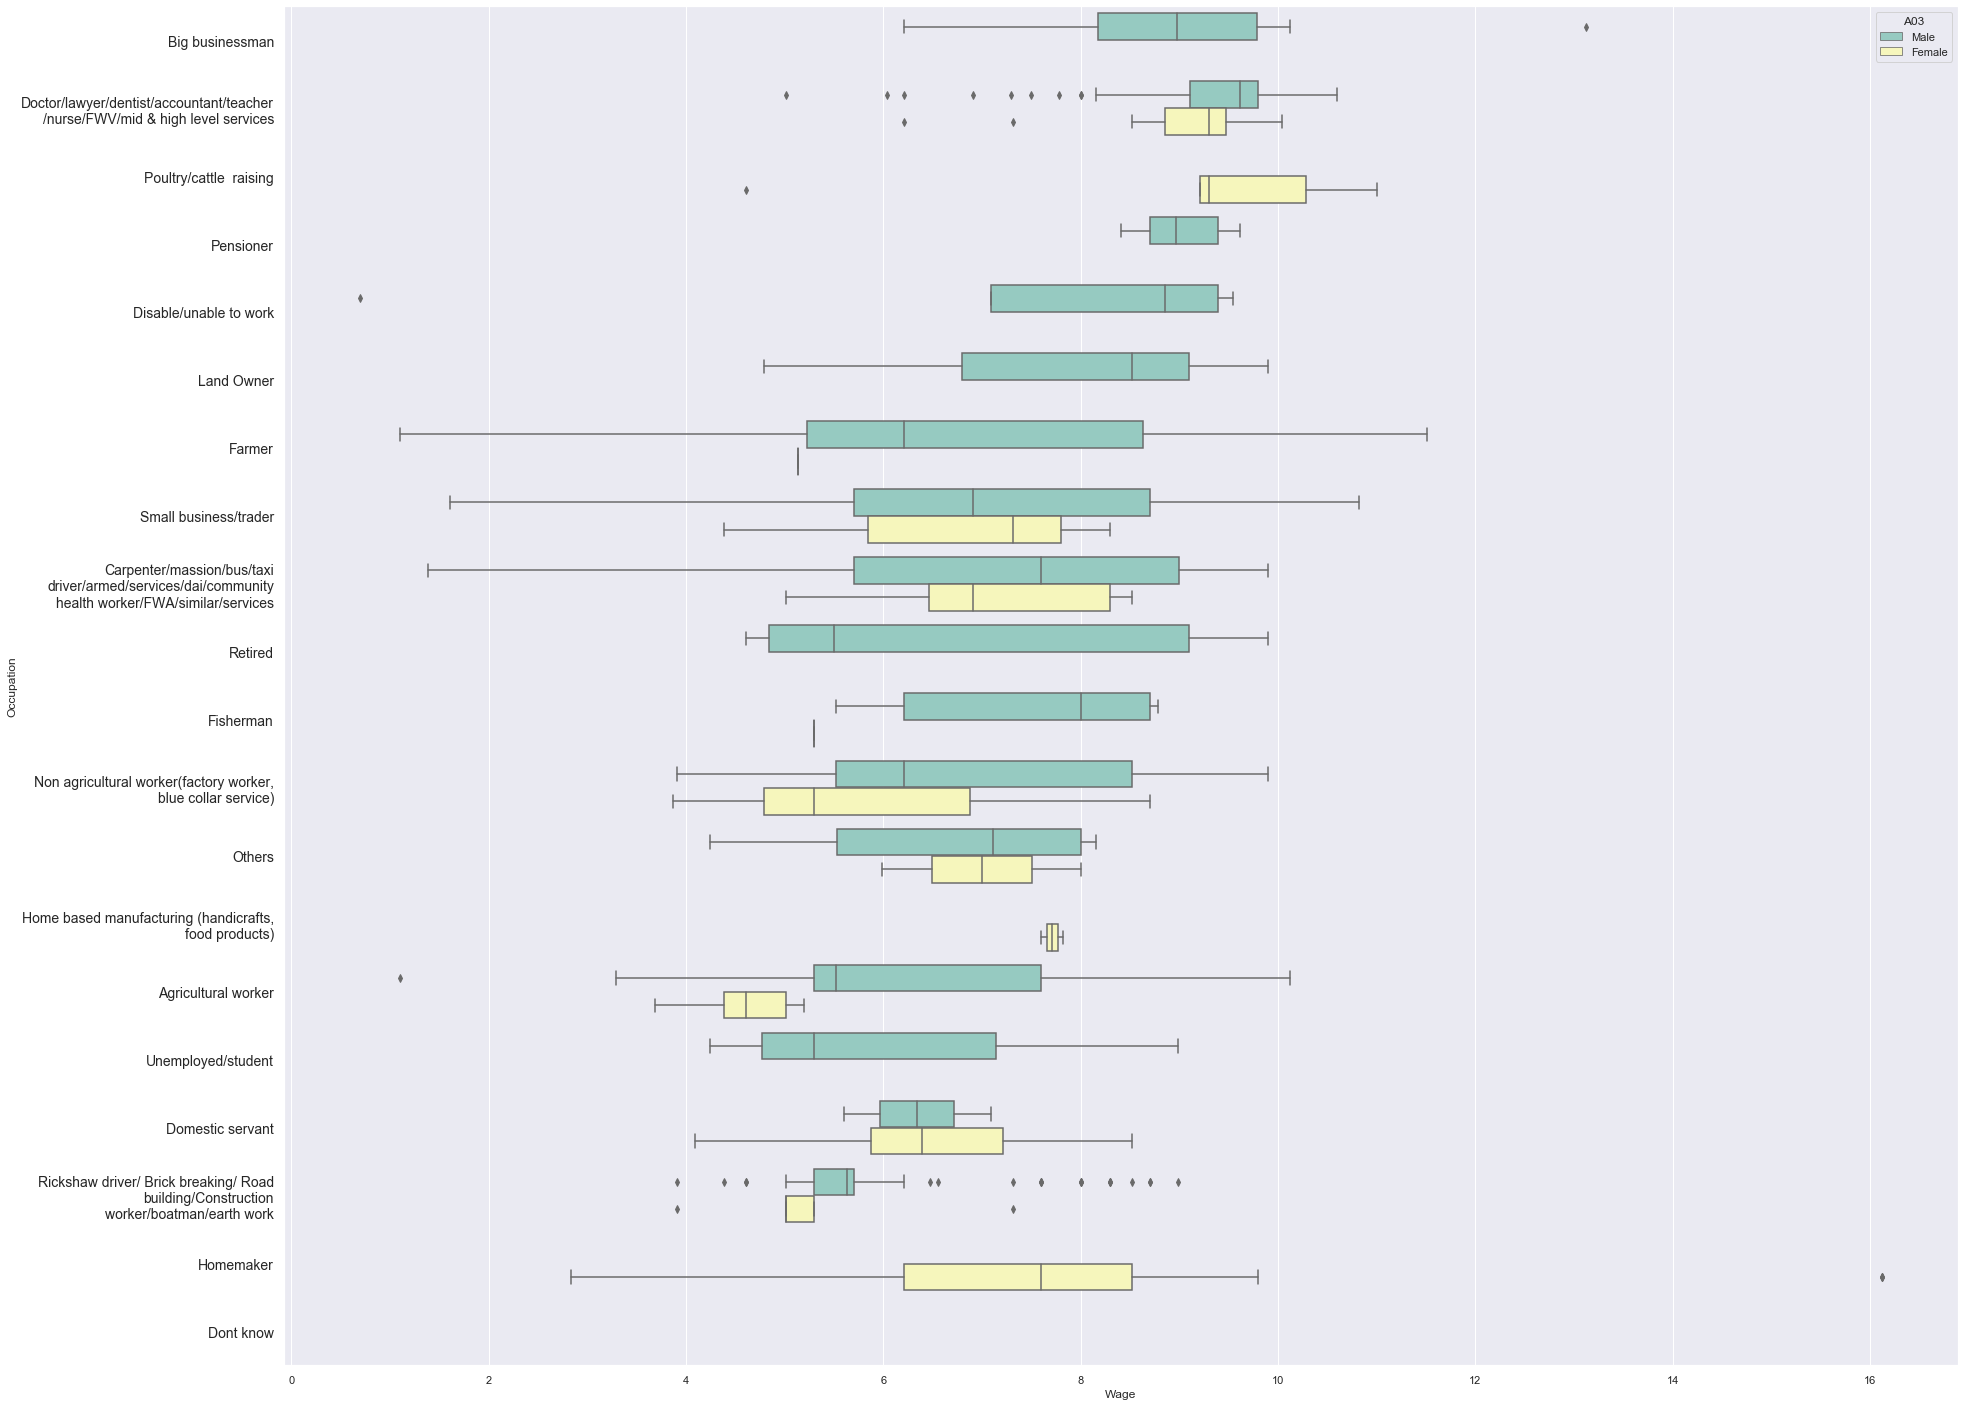

In [107]:
# The average wage(earning after migration) for each occupation. Ranked from highest to lowest.

plt.figure(figsize=(30, 25))
df_person_log = df_person.copy()
df_person_log["D1_10Al"] = np.where(df_person_log["D1_10Al"]>0, np.log(df_person_log["D1_10Al"]), 0)
plot = sns.boxplot(x="D1_10Al", y="A14", hue="A03", data=df_person_log[df_person_log["D1_10Al"]>0], palette="Set3", order=ranking1)
labels = [label.get_text() for label in plot.get_yticklabels()]
labels = ["\n".join(wrap(label, 40)) for label in labels]
plot.set_yticklabels(labels, fontsize=14);
plot.set(xlabel="Wage", ylabel="Occupation");

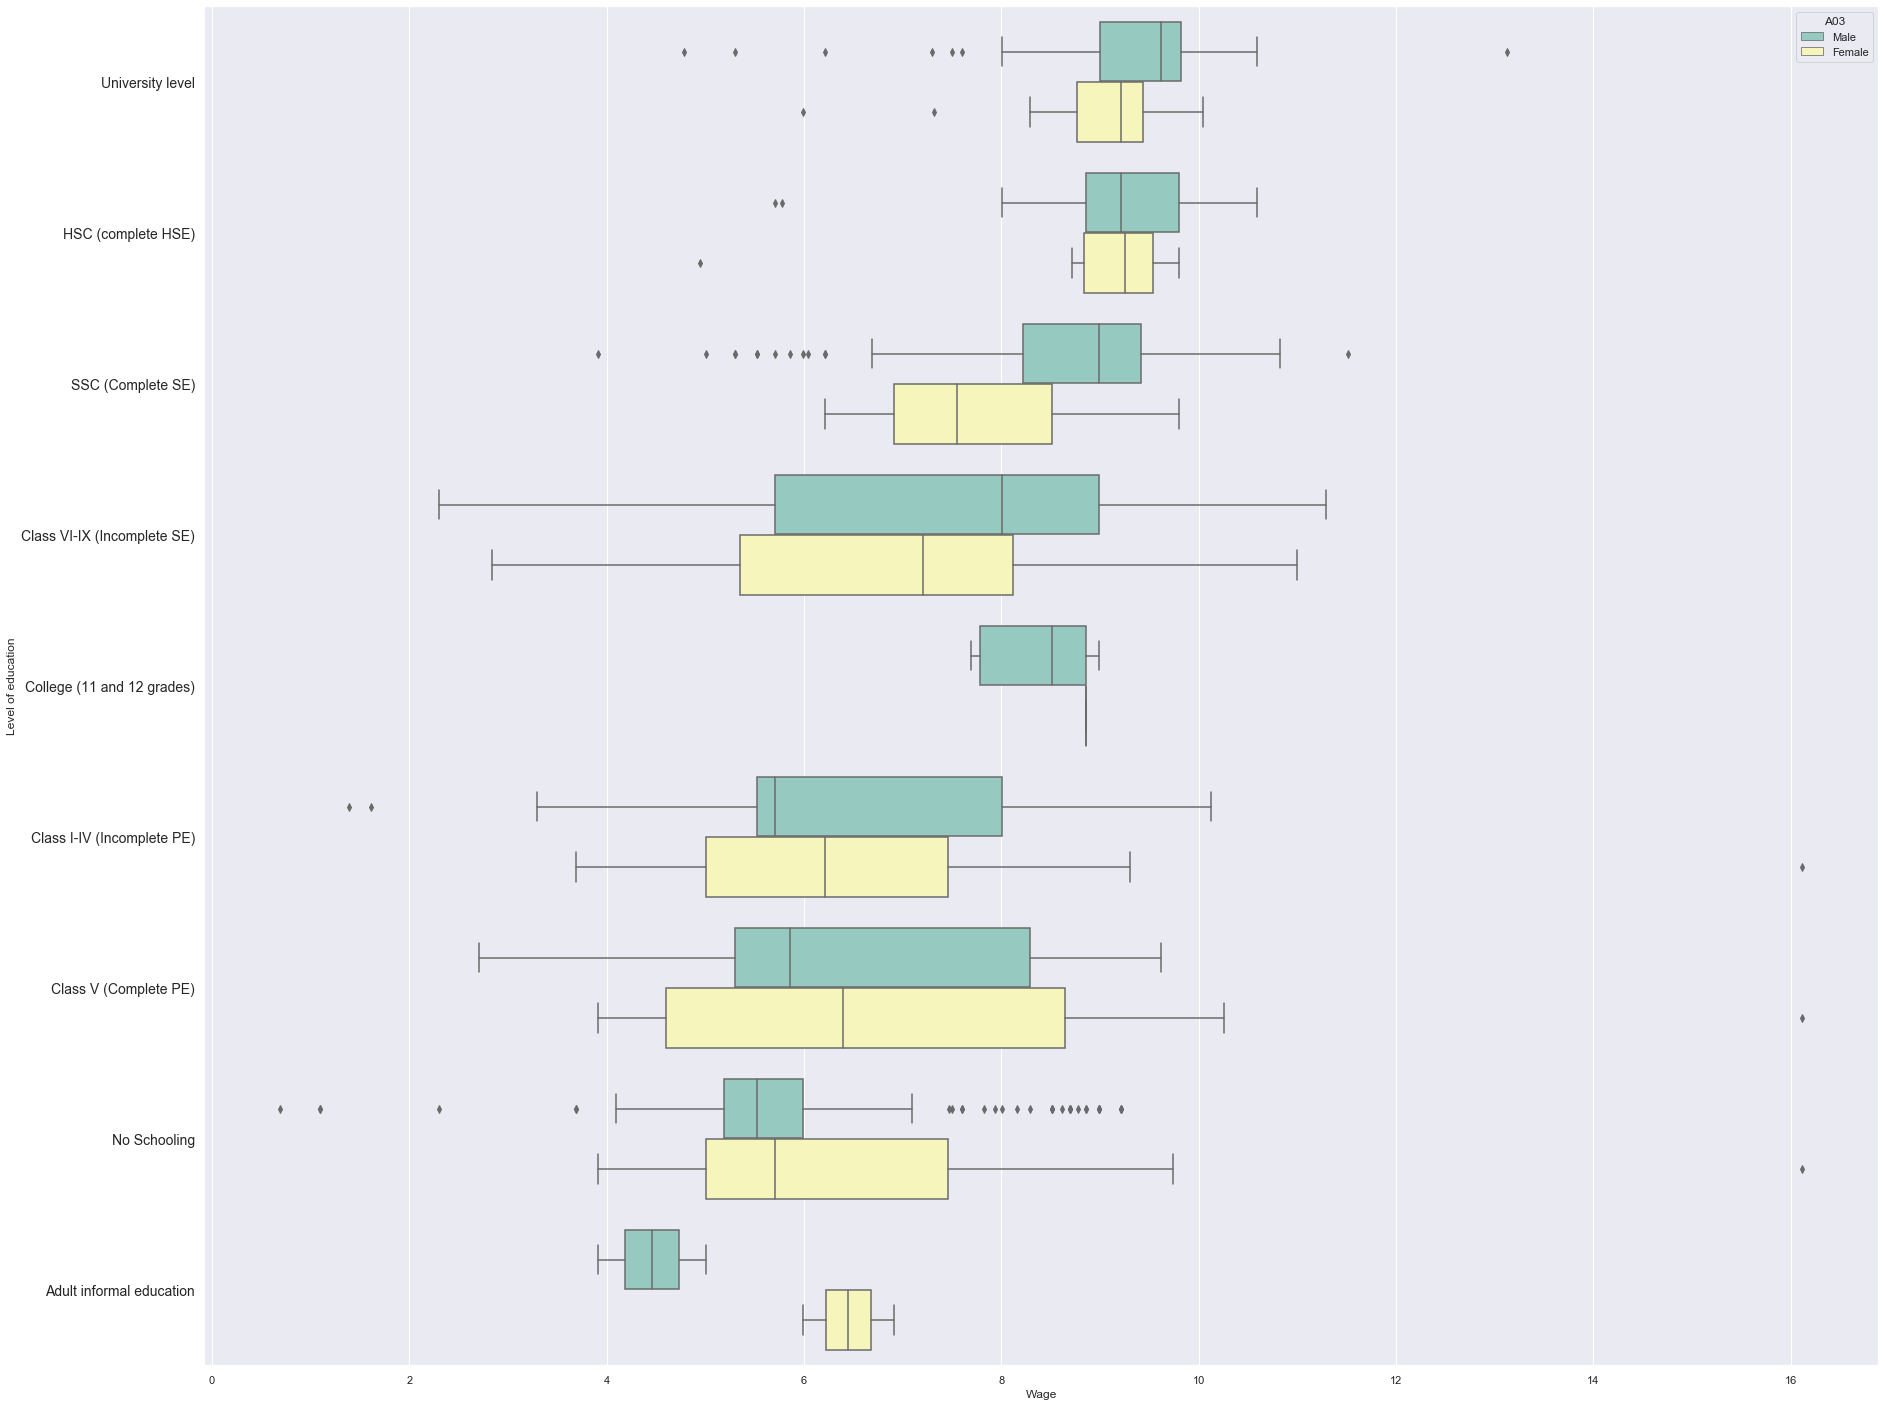

In [108]:
# The average wage(earning after migration) for each education level. Ranked from highest to lowest.

plt.figure(figsize=(30, 25))
df_person_log = df_person.copy()
df_person_log["D1_10Al"] = np.where(df_person_log["D1_10Al"]>0, np.log(df_person_log["D1_10Al"]), 0)
plot = sns.boxplot(x="D1_10Al", y="A13", hue="A03", data=df_person_log[df_person_log["D1_10Al"]>0], palette="Set3", order=ranking2)
labels = [label.get_text() for label in plot.get_yticklabels()]
labels = ["\n".join(wrap(label, 40)) for label in labels]
plot.set_yticklabels(labels, fontsize=14);
plot.set(xlabel="Wage", ylabel="Level of education");

In [98]:
# Calculate summary statistics
df_person_salary.groupby("A14")["D1_10Al"].mean().sort_values(ascending=False)

A14
Big businessman                                                                                      37472.222222
Doctor/lawyer/dentist/accountant/teacher/nurse/FWV/mid & high level services                         13474.935065
Poultry/cattle  raising                                                                              11330.000000
Pensioner                                                                                             9088.888889
Disable/unable to work                                                                                6840.400000
Land Owner                                                                                            6065.000000
Farmer                                                                                                5879.114286
Small business/trader                                                                                 4307.239583
Carpenter/massion/bus/taxi driver/armed/services/dai/community health worker/FWA/sim

In [99]:
df_person_salary.groupby("A13")["D1_10Al"].mean().sort_values(ascending=False)

A13
University level               14243.225806
HSC (complete HSE)              6717.785714
SSC (Complete SE)               4620.482759
Class VI-IX (Incomplete SE)     2596.955923
College (11 and 12 grades)      1755.555556
Class I-IV (Incomplete PE)      1406.165517
Class V (Complete PE)           1238.260870
No Schooling                     863.275000
Adult informal education         400.000000
Name: D1_10Al, dtype: float64

# Land Distribution

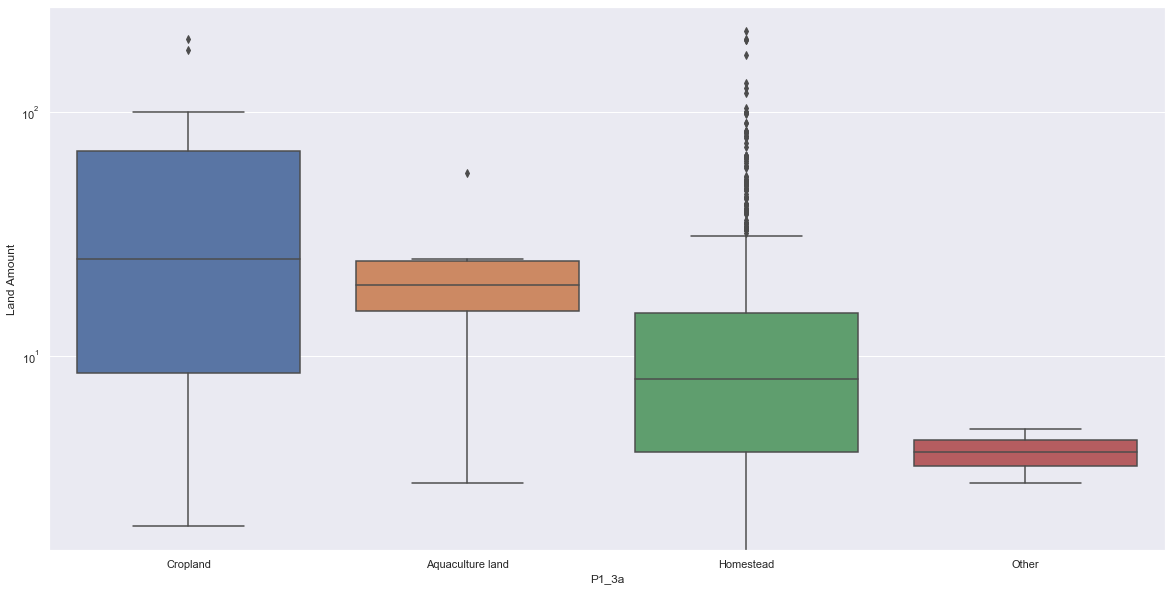

In [97]:
# boxplot for each land type

plt.figure(figsize=(20, 10))
plot = sns.boxplot(y = "P1_2a", x = "P1_3a", data=df_house)
plot.set_yscale('log')
plot.set_ylabel("Land Amount");

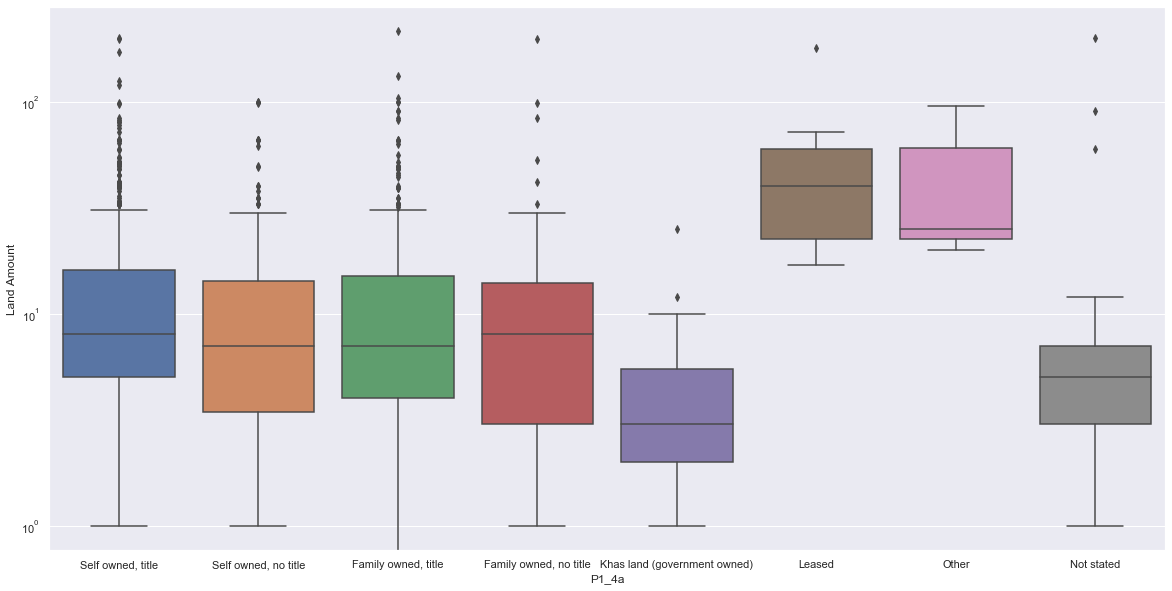

In [98]:
#box plot for each land tenancy type

plt.figure(figsize=(20, 10))
plot = sns.boxplot(y = "P1_2a", x = "P1_4a", data=df_house)
plot.set_yscale('log')
plot.set_ylabel("Land Amount");

In [100]:
land_amount_cols = ["P1_2{}".format(chr(i)) for i in range(97, 105)]
land_type_cols = ["P1_3{}".format(chr(i)) for i in range(97, 105)]
land_tenancy_cols = ["P1_4{}".format(chr(i)) for i in range(97, 105)]

In [101]:
# aggregate the total earnings for each household

df_house["land_total"] = df_house[land_amount_cols].sum(axis=1)
for index, value in df_house["h_idnumber"].items():
    income = df_person[df_person["h_idnumber"] == value]["D1_10Al"].sum()
    df_house.loc[index, "income_total"] = income
    print(index, end="\r")

## There is no significant correlation between the total area of land, total earning, # of workers, and # of members. This result is summarized in the correlation matrix at the end of this section.

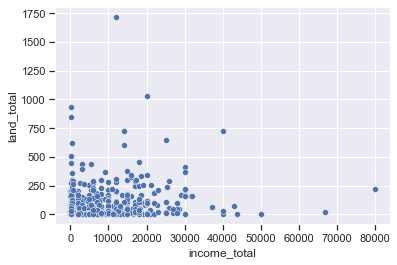

In [219]:
sns.scatterplot(x="income_total", y="land_total", data=df_house[(df_house["income_total"]<100000) & (df_house["income_total"]>0)])

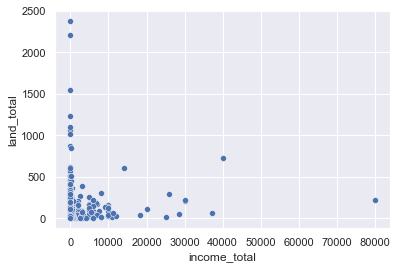

In [144]:
sns.scatterplot(x="income_total", y="land_total", data=df_house[(df_house["income_total"]<100000) & (df_house["hocc"].isin(["Agricultural worker", "Farmer", "Land Owner"]))])

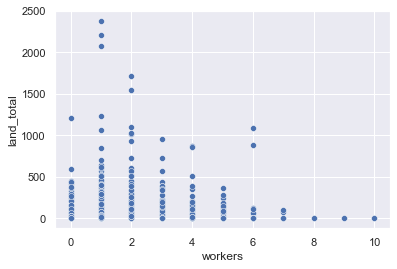

In [149]:
sns.scatterplot(x="workers", y="land_total", data=df_house)

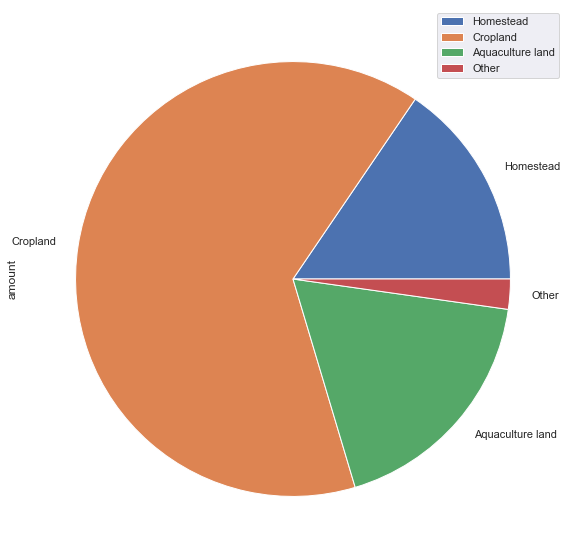

In [102]:
# pie chart for land type distribution

land_type_df = pd.DataFrame(columns=["type", "amount"])
for index, land_type in enumerate(df_house["P1_3a"].unique()):
    amount = 0
    for i in range(8):
        amount += df_house[df_house[land_type_cols[i]]==land_type][land_amount_cols[i]].sum()
    land_type_df.loc[index, "type"] = land_type
    land_type_df.loc[index, "amount"] = amount

land_type_df.dropna(inplace=True)
land_type_df = land_type_df.set_index(land_type_df["type"])

land_type_df.plot.pie(y="amount", figsize=(10, 10))

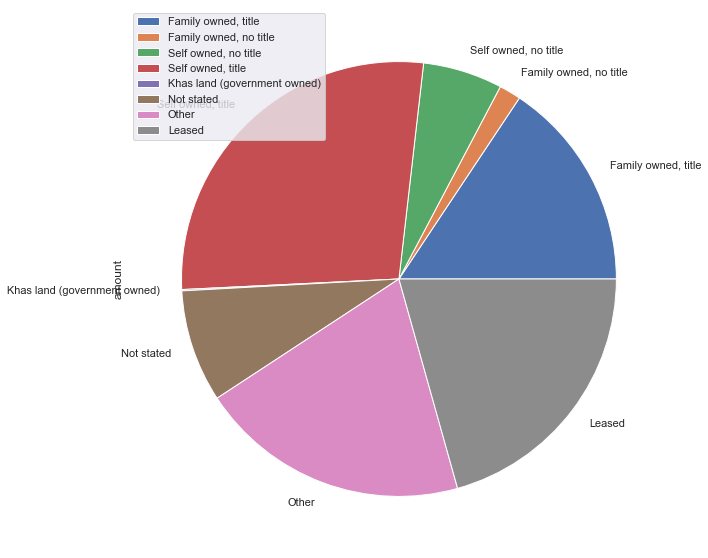

In [103]:
# pie chart for land tenancy distribution

land_df = pd.DataFrame(columns=["type", "amount"])
for index, land_type in enumerate(df_house["P1_4a"].unique()):
    amount = 0
    for i in range(8):
        amount += df_house[df_house[land_tenancy_cols[i]]==land_type][land_amount_cols[i]].sum()
    land_df.loc[index, "type"] = land_type
    land_df.loc[index, "amount"] = amount

land_df.dropna(inplace=True)
land_df = land_df.set_index(land_df["type"])
land_df.plot.pie(y="amount", figsize=(10, 10))

In [188]:
# build a dataframe summarizing the area of each type of land, number of members and workers, 
# and total wage(not the actual wage) for each household

land_df = pd.DataFrame(columns=list(df_house["P1_4a"].unique()))
factors = ["income_total", "members", "workers"]
land_df[factors] = df_house[factors]
for index, row in df_house.iterrows():
    for land_type in df_house["P1_4a"].unique():
        amount = 0
        for i in range(8):
            if row[land_tenancy_cols[i]]==land_type:
                amount += float(row[land_amount_cols[i]])
        land_df.loc[index, land_type] = amount
    print(index, end="\r")

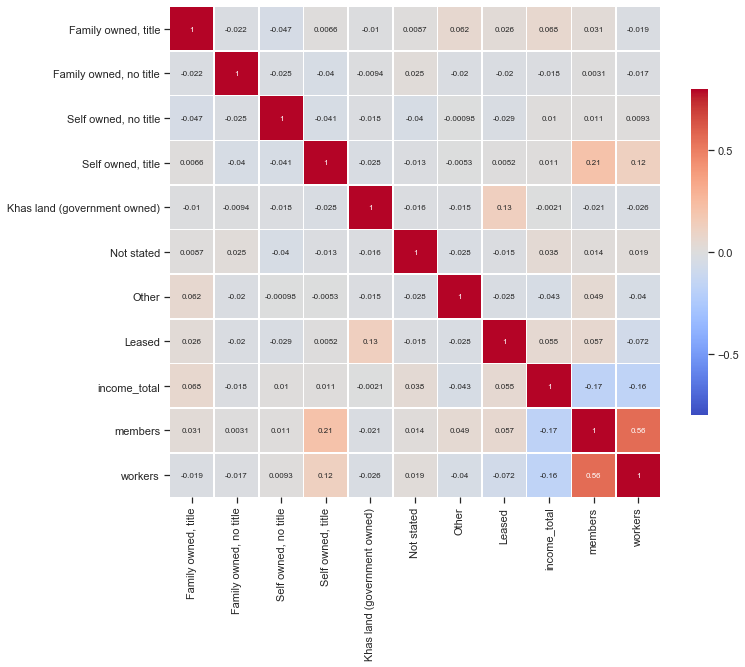

In [218]:
# remove outliers
land_df = land_df[(np.abs(stats.zscore(land_df["income_total"])<3))]

# convert to numeric
for column in land_df.columns:
    land_df[column] = pd.to_numeric(land_df[column])

# draw a correlation heatmap
features = list(land_df.columns)
features.pop(4)
corr_matrix = land_df[land_df["income_total"]>0][features].corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)

f, ax = plt.subplots(figsize=(11, 15)) 
heatmap = sns.heatmap(corr_matrix, 
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -0.8, 
                      vmax = 0.8,
                      annot = True,
                      annot_kws = {'size': 8})
#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

# Household size distribution (Members & Workers)

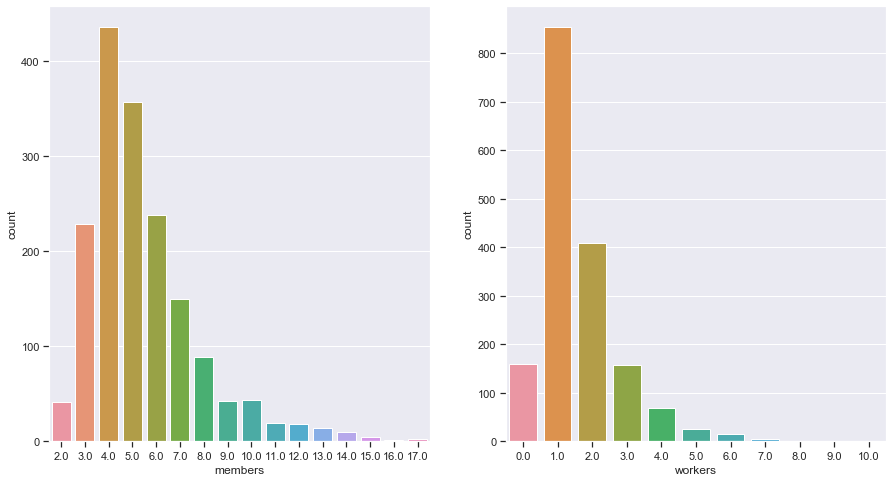

In [261]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
sns.countplot(x = df_house["members"], ax=axes[0])
sns.countplot(x = df_house["workers"], ax=axes[1])

# What age do they start work/school?

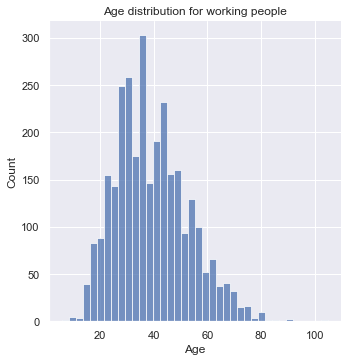

In [104]:
non_work = ["Unemployed/student", "Disable/unable to work", "Domestic servant", 
            'Others', 'Dont know', 'Retired', 'Pensioner', "Homemaker" ]
work_types = [occupation for occupation in list(df_person.A14.unique()) if (occupation not in non_work) and (type(occupation)!=float)]
plot = sns.displot(df_person[(df_person["A14"].isin(work_types)) & (df_person["Age"].astype(str).str.isdigit())], x="Age")
plot.set(title="Age distribution for working people")

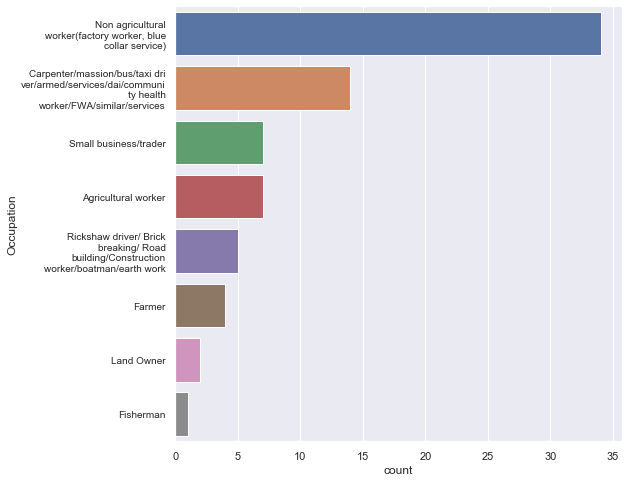

In [105]:
df_person_copy = df_person[df_person["Age"] != "N/A"]
df_person_copy = df_person_copy[(df_person_copy["A14"].isin(work_types)) & (df_person_copy["Age"].astype(int, errors="ignore")<18)]
df_person_copy["A14"] = df_person_copy["A14"].cat.remove_unused_categories()
order = df_person_copy["A14"].value_counts().index
plt.figure(figsize=(8, 8))
plot = sns.countplot(y="A14", data=df_person_copy, order=order);
labels = [label.get_text() for label in plot.get_yticklabels()];
labels = ["\n".join(wrap(label, 30)) for label in labels]
plot.set_yticklabels(labels, fontsize=10);
plot.set_ylabel("Occupation");

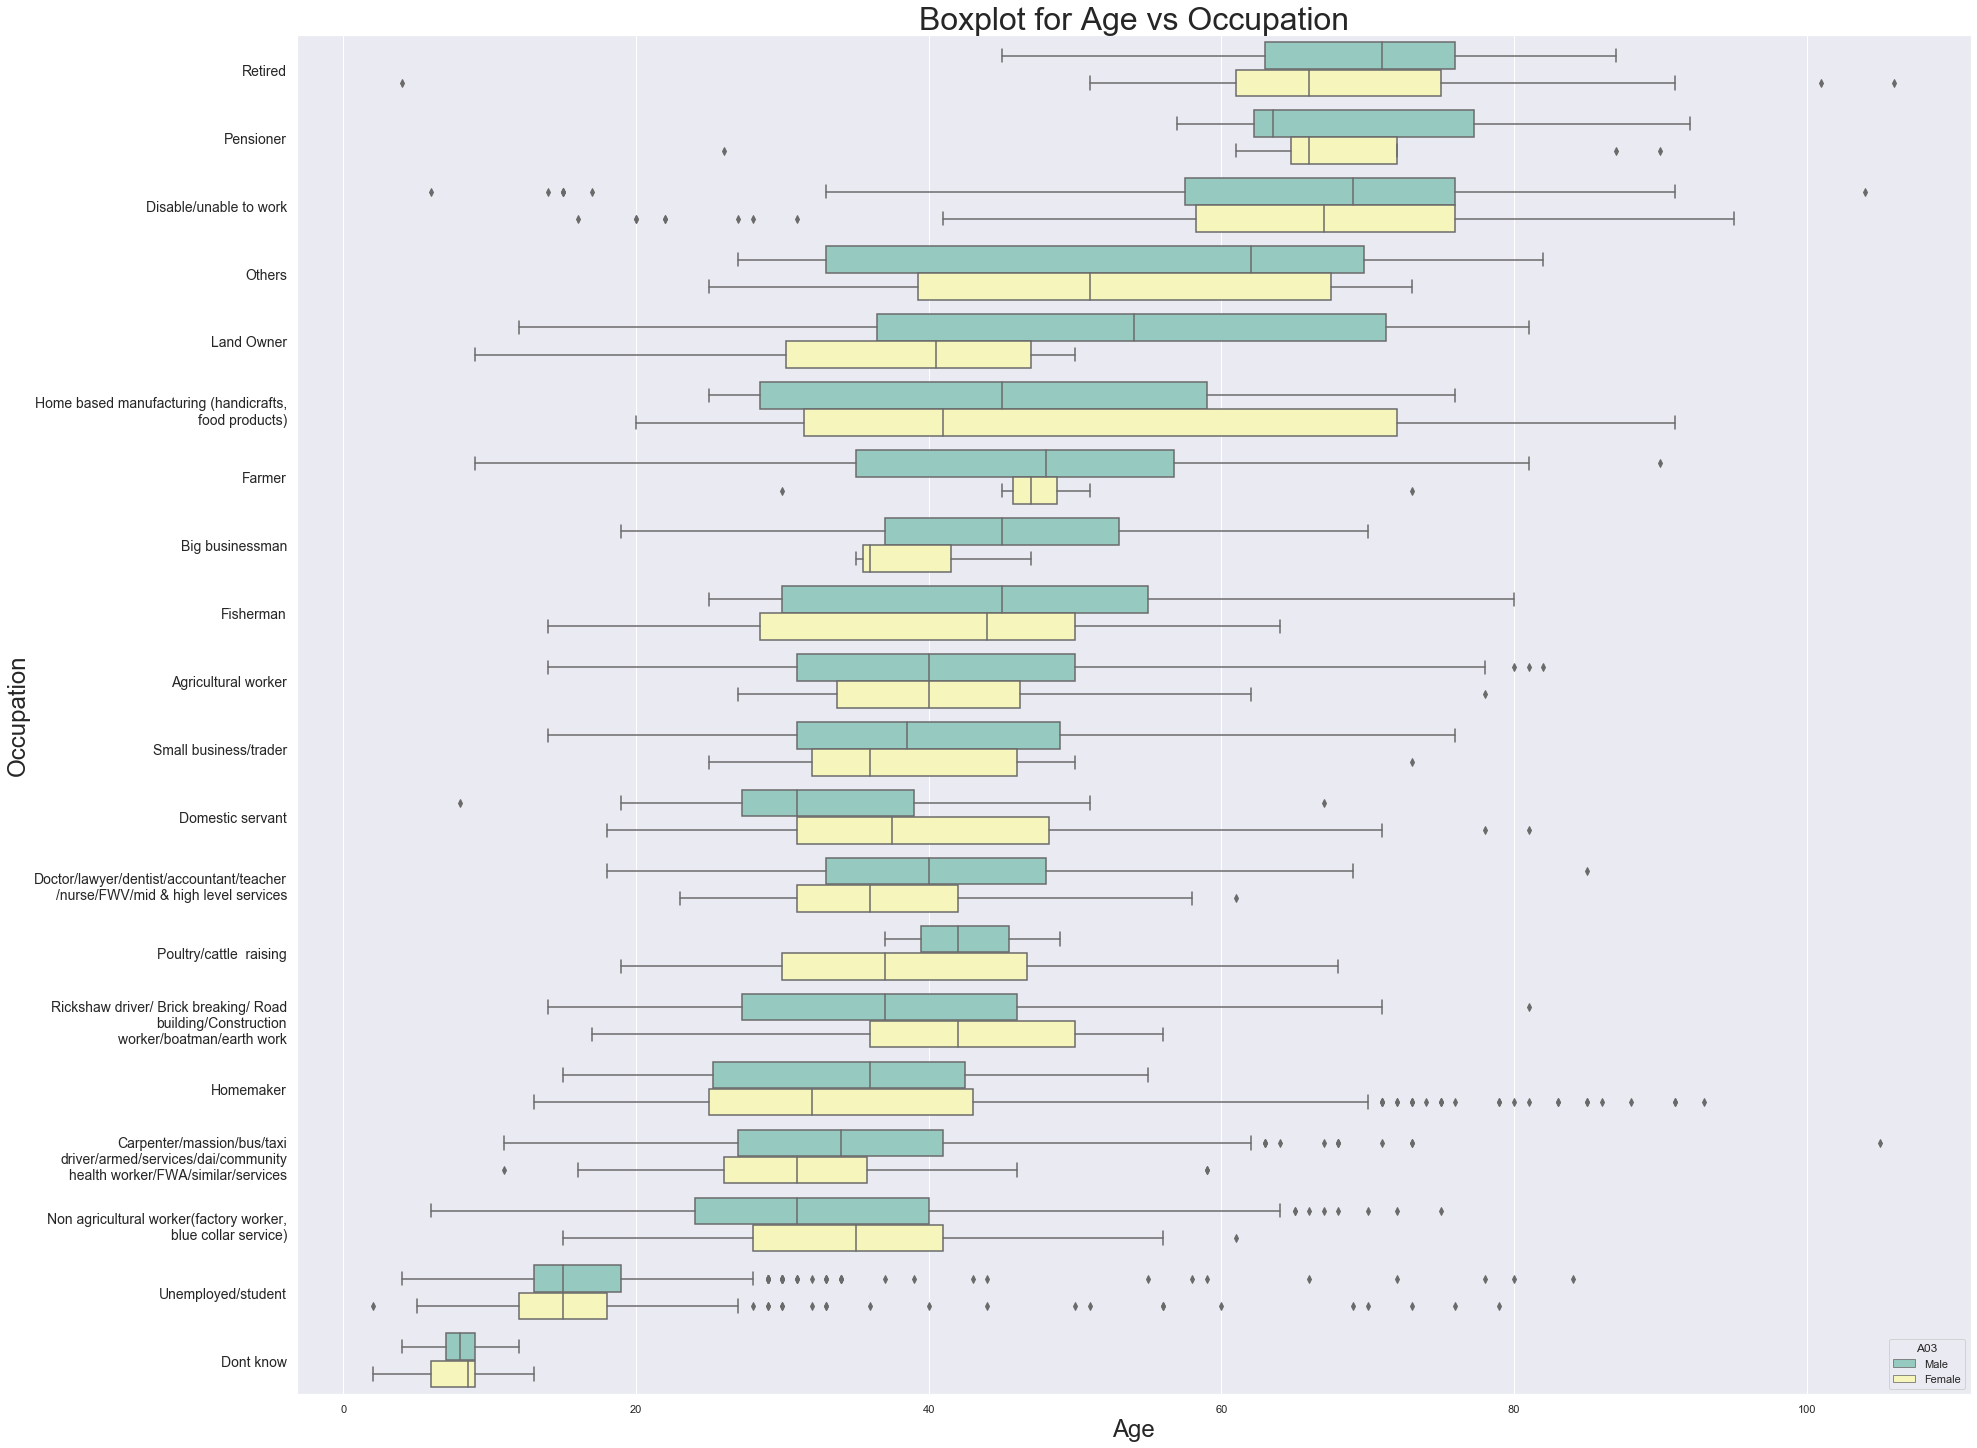

In [138]:
# Age distribution for each occupation
plt.figure(figsize=(30, 25))
df_person_copy = df_person[df_person["Age"] != "N/A"].copy()
df_person_copy["Age"] = pd.to_numeric(df_person_copy["Age"])
ranking3 = df_person_copy.groupby("A14")["Age"].mean().sort_values(ascending=False).index
plot = sns.boxplot(x="Age", y="A14", hue="A03", data=df_person_copy, palette="Set3", order=ranking3)
labels = [label.get_text() for label in plot.get_yticklabels()]
labels = ["\n".join(wrap(label, 40)) for label in labels]
plot.set_yticklabels(labels, fontsize=14);
plot.set_title("Boxplot for Age vs Occupation", fontsize=32);
plot.set_xlabel("Age", fontsize=24);
plot.set_ylabel("Occupation", fontsize=24);

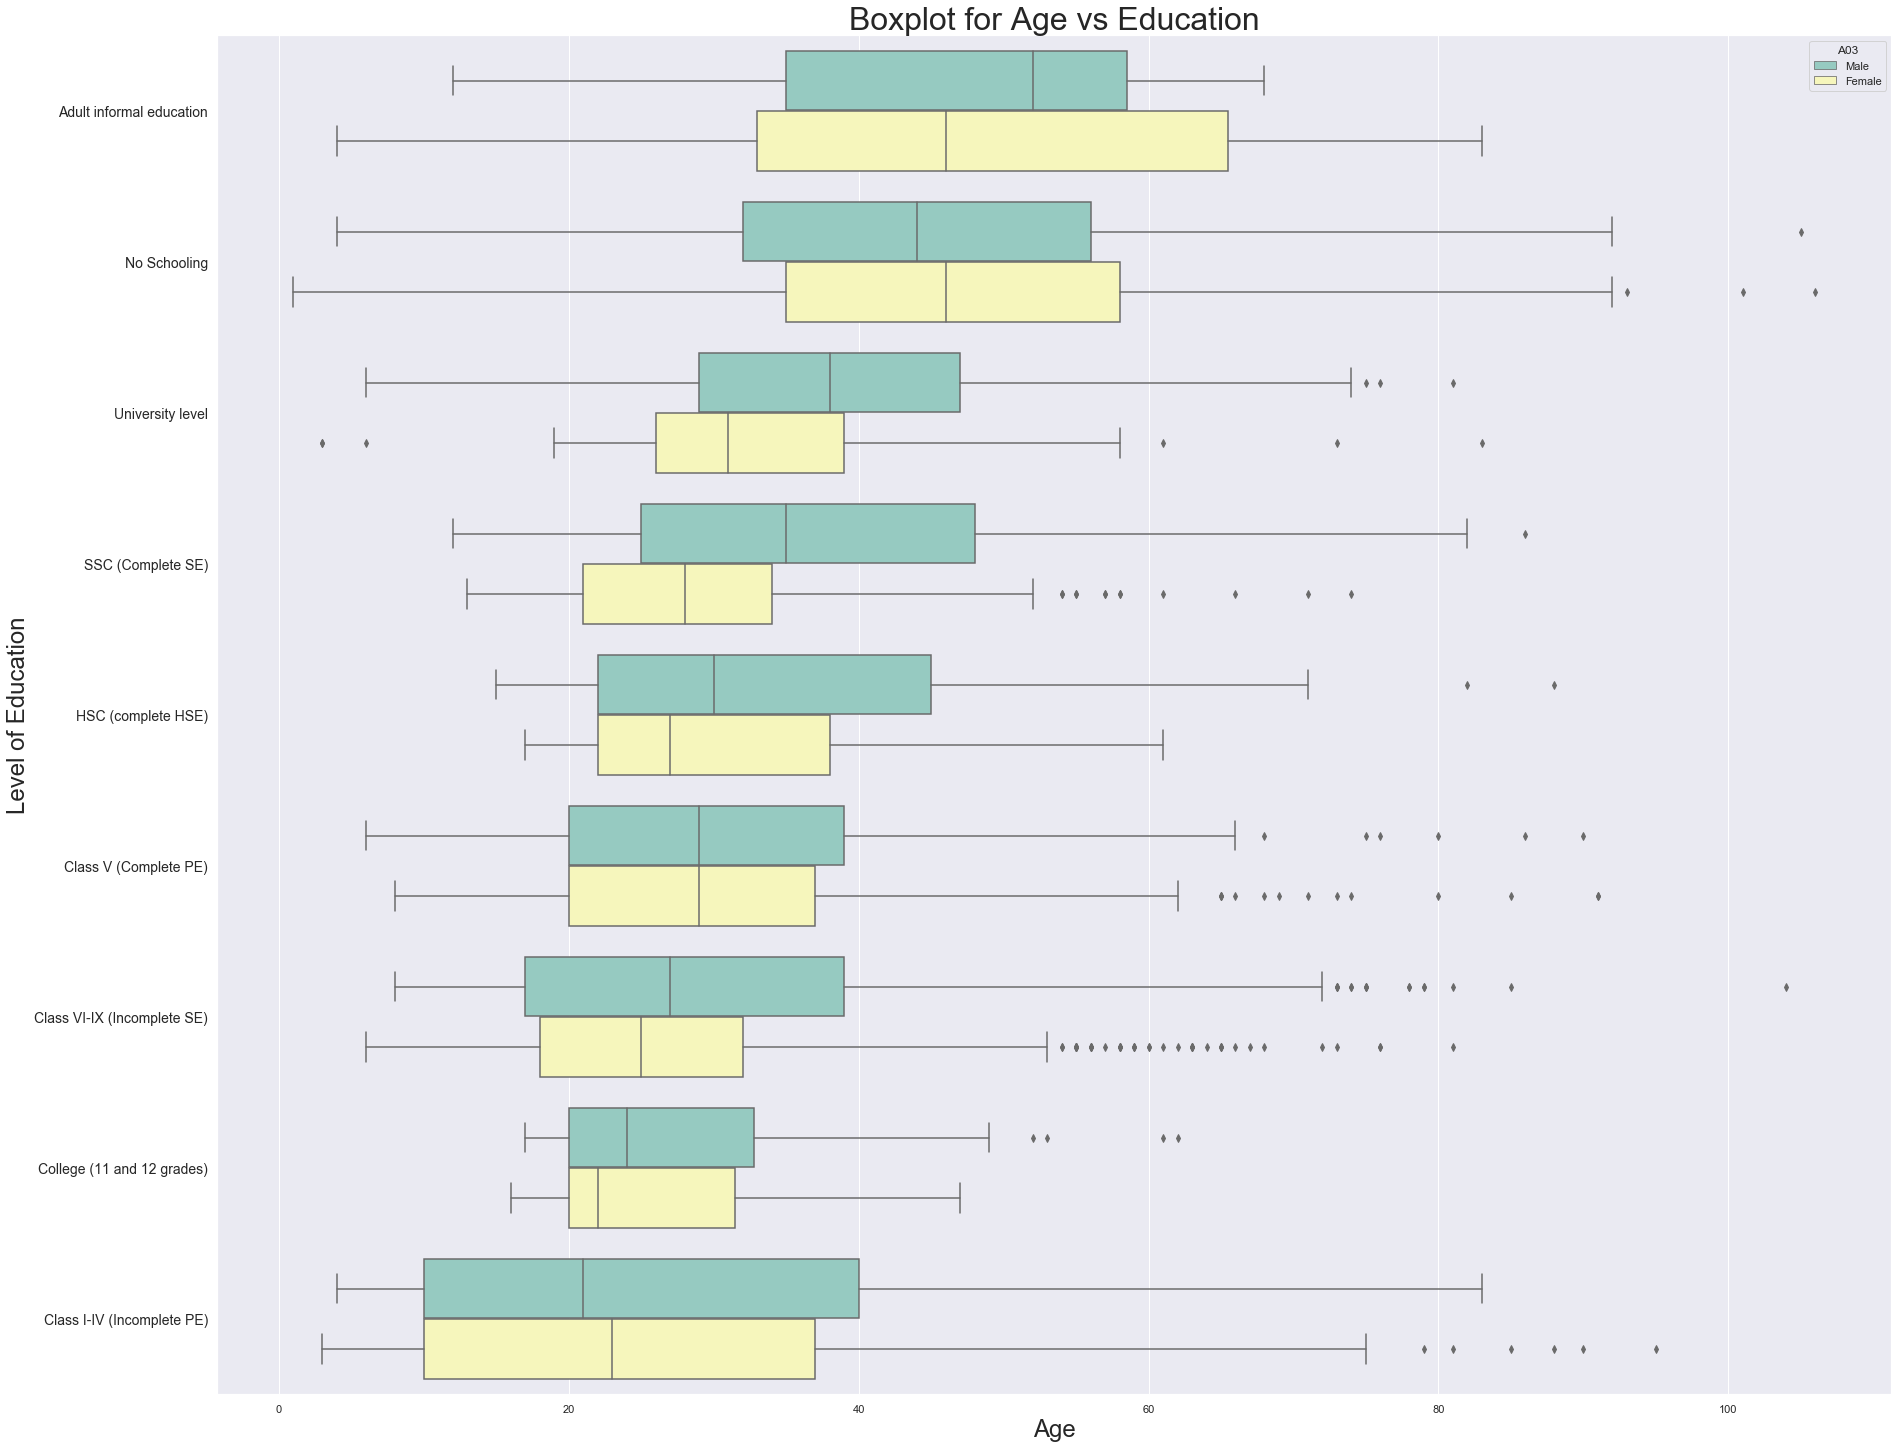

In [140]:
# Age distribution for each occupation
plt.figure(figsize=(30, 25))
df_person_copy = df_person[df_person["Age"] != "N/A"].copy()
df_person_copy["Age"] = pd.to_numeric(df_person_copy["Age"])
ranking4 = df_person_copy.groupby("A13")["Age"].mean().sort_values(ascending=False).index
plot = sns.boxplot(x="Age", y="A13", hue="A03", data=df_person_copy, palette="Set3", order=ranking4)
labels = [label.get_text() for label in plot.get_yticklabels()]
labels = ["\n".join(wrap(label, 40)) for label in labels]
plot.set_yticklabels(labels, fontsize=14);
plot.set_title("Boxplot for Age vs Education", fontsize=32);
plot.set_xlabel("Age", fontsize=24);
plot.set_ylabel("Level of Education", fontsize=24);

# Remittance

In [176]:
df_house["Remittance"] = df_house["J4_5a"].fillna(0) + df_house["J4_5b"].fillna(0) + df_house["J4_5c"].fillna(0)
df_house["Received_remittance"] = df_house["Remittance"].apply(lambda x: "received" if x>0 else "not received")
df_house["Total_trips"] = df_house[["totalinternal", "totalindia", "totalother"]].fillna(0).sum(axis=1)

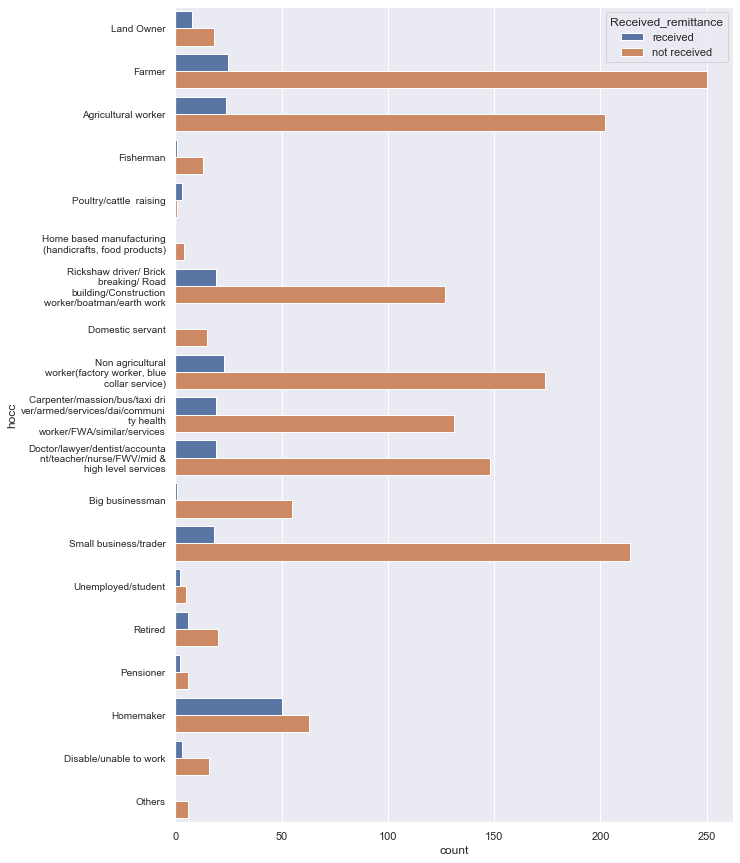

In [184]:
plt.figure(figsize=(10, 15))
plot = sns.countplot(y="hocc", hue= "Received_remittance", data=df_house)
labels = [label.get_text() for label in plot.get_yticklabels()]
labels = ["\n".join(wrap(label, 30)) for label in labels]
plot.set_yticklabels(labels, fontsize=10);

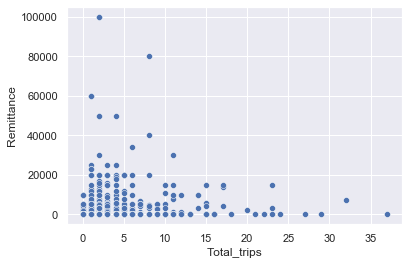

In [181]:
sns.scatterplot(x="Total_trips", y="Remittance", data=df_house)

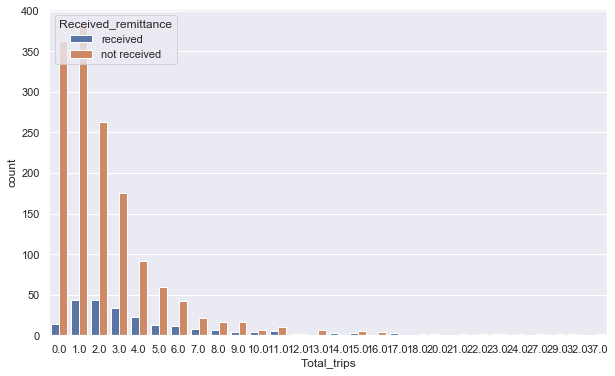

In [186]:
plt.figure(figsize=(10, 6))
sns.countplot(x="Total_trips", hue="Received_remittance", data=df_house)